# Reconocimiento de cactus

Cactus recognition using LeNet5. 

Now i am testing random vertical flip

## Dataset

In [1]:
# notebook configuration

display_dataset = True
load_weights = False
reading_weights_file = 'weights/nbv_net_no_drop.pth'
saving_weights_file = 'weights/weights.pth'
epochs = 150
batch_size = 2500
learning_rate = 0.001

In [2]:
# importamos paquetes
# Cargamos paquetes necesarios

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torchvision import datasets, transforms


In [3]:
#check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [4]:
# directorio de la carpeta
directorio = 'cactus_dataset2'

# aplicaré una serie de transformaciones
# 1. escalar las imágenes a 32 x 32 pixeles
# 2. convertir a tensores
transformaciones_training = transforms.Compose([transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

trainset = datasets.ImageFolder(directorio + '/training_set', transformaciones_training) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)


# aplicaré una serie de transformaciones
# 1. escalar las imágenes a 32 x 32 pixeles
# 2. convertir a tensores
transformaciones_validacion = transforms.Compose([transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(), 
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Descargamos el conjunto de validación
testset = datasets.ImageFolder(directorio + '/validation_set', transform=transformaciones_validacion)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

# Print out some stats about the training and test data
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

# specify the image classes
classes = ['cactus', 'no_cactus']

Train data, number of images:  17500
Test data, number of images:  4000


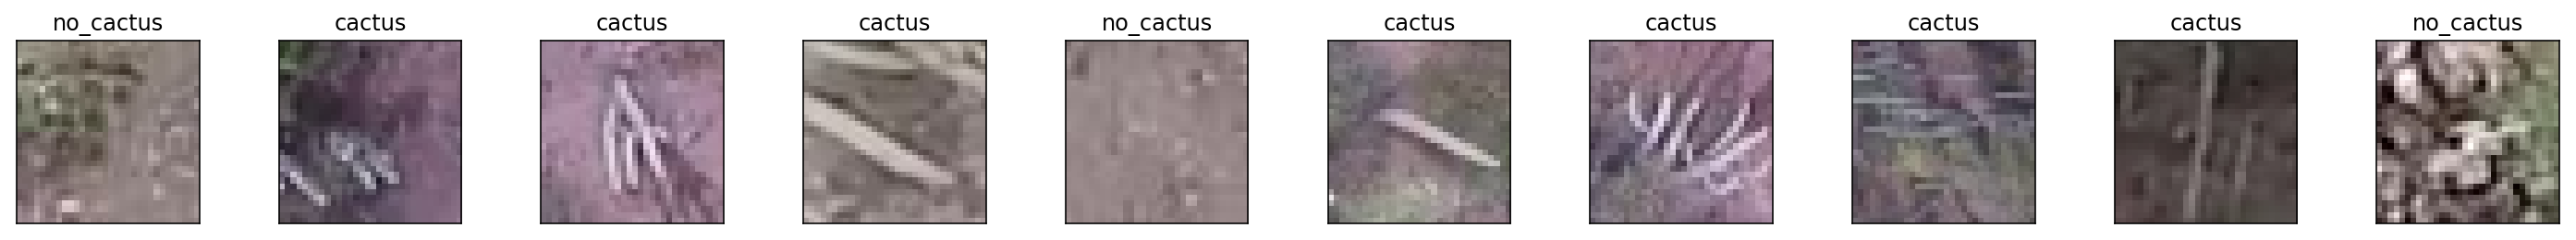

In [5]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

display_size = 10

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.numpy().transpose((1, 2, 0))
    image = (image + np.ones(image.shape))/2
    ax.imshow(image)
    ax.set_title(classes[labels[idx]])

# LeNet5

In [6]:
class LeNet5(nn.Module):
    def __init__(self, n_clases):
        '''
        Construimos la estructura de LeNet5
        
        '''
        super(LeNet5, self).__init__()
        
        # De acuerdo al artículo de LeCun La primera capa está compuesta por 6 kernels de 5x5
        self.conv1 = nn.Conv2d(3, 6, 5) # 1 canal de entrada 6 feature maps de salida, kernels de 5x5
        
        # Después tenemos una capa maxpooling
        # kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Agregamos otra capa convolucional con 16 kernels de 5 x 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Maxpooling
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_clases)
    
    def forward(self, x):
        '''
        Definimos el pase frontal (forward pass)
        '''
        # Agregamos los ReLUs
        x = self.pool1(F.relu(self.conv1(x)))
        #print(x.size())
        x = self.pool2(F.relu(self.conv2(x)))

        # prep for linear layer by flattening the feature maps into feature vectors
        x = x.view(x.size(0), -1)
        # capas lineales
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    

In [7]:
model = LeNet5(10)
model.to(device)
print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Entrenamiento

In [8]:
# define the criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Implementamos una función de evaluación
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        # warp input images in a Variable wrapper
        images = Variable(images)
        images = images.to(device)
        
        labels = Variable(labels)
        labels = labels.to(device)
        
        output = model.forward(images)
        
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
        
        

    # forward pass to get outputs
    # the outputs are a series of class scores
    #outputs = model(images)

    # get the predicted class from the maximum value in the output-list of class scores
    #_, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    #total += labels.size(0)
    #correct += (predicted == labels).sum()

    
    return test_loss, accuracy

In [10]:
from torch.autograd import Variable

#hiperparámetro

steps = 0
running_loss = 0
print_every = 40

save_after = 100

history_epoch = []
history_train_loss = []
history_validation_loss = []
history_train_accuracy = []
history_validation_accuracy = []

import time
tic = time.clock()

for e in range(epochs):
    # Cambiamos a modo entrenamiento
    model.train()
    
    #for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
    #        inputs, labels = data
    
    for images, labels in trainloader:
        steps += 1
        
        # Aplanar imágenes a un vector de 784 elementos
        # images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # wrap them in a torch Variable
        images, labels = Variable(images), Variable(labels)  
        
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
    
    # Cambiamos a modo de evaluación
    model.eval()
    
    # Apagamos los gradientes, reduce memoria y cálculos
    with torch.no_grad():
        train_loss, train_accuracy = validation(model, trainloader, criterion)
        val_loss, val_accuracy = validation(model, testloader, criterion)
        
        train_loss, train_accuracy = train_loss, train_accuracy.cpu().numpy()
        val_loss, val_accuracy = val_loss, val_accuracy.cpu().numpy()
        
        train_accuracy = train_accuracy / len(trainloader)
        val_accuracy = val_accuracy / len(testloader)
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Val. Loss: {:.3f}.. ".format(val_loss),
              "Train Accuracy: {:.3f}".format(train_accuracy),
              "Val. Accuracy: {:.3f}".format(val_accuracy))
    
    history_epoch.append(e)
    history_train_loss.append(train_loss)
    history_validation_loss.append(val_loss)
    history_train_accuracy.append(train_accuracy)
    history_validation_accuracy.append(val_accuracy)
    
    running_loss = 0
    
    if(e % save_after == 0):
        np.save('log/train_loss', history_train_loss)
        np.save('log/validation_loss', history_validation_loss)
        np.save('log/train_accuracy', history_train_accuracy)
        np.save('log/validation_accuracy', history_validation_accuracy)
        torch.save(model.state_dict(), 'log/weights.pth')
    
    # Make sure training is back on
    model.train()
    
toc = time.clock()
print(toc - tic)

Epoch: 1/150..  Training Loss: 12.580..  Val. Loss: 3.772..  Train Accuracy: 0.751 Val. Accuracy: 0.751
Epoch: 2/150..  Training Loss: 5.870..  Val. Loss: 1.681..  Train Accuracy: 0.751 Val. Accuracy: 0.745
Epoch: 3/150..  Training Loss: 3.902..  Val. Loss: 1.055..  Train Accuracy: 0.751 Val. Accuracy: 0.753
Epoch: 4/150..  Training Loss: 3.840..  Val. Loss: 1.012..  Train Accuracy: 0.751 Val. Accuracy: 0.751
Epoch: 5/150..  Training Loss: 3.661..  Val. Loss: 0.964..  Train Accuracy: 0.751 Val. Accuracy: 0.749
Epoch: 6/150..  Training Loss: 3.597..  Val. Loss: 0.969..  Train Accuracy: 0.751 Val. Accuracy: 0.748
Epoch: 7/150..  Training Loss: 3.540..  Val. Loss: 0.966..  Train Accuracy: 0.751 Val. Accuracy: 0.752
Epoch: 8/150..  Training Loss: 3.480..  Val. Loss: 0.975..  Train Accuracy: 0.751 Val. Accuracy: 0.748
Epoch: 9/150..  Training Loss: 3.402..  Val. Loss: 0.954..  Train Accuracy: 0.751 Val. Accuracy: 0.749
Epoch: 10/150..  Training Loss: 3.308..  Val. Loss: 0.919..  Train Accur

Epoch: 80/150..  Training Loss: 0.582..  Val. Loss: 0.466..  Train Accuracy: 0.971 Val. Accuracy: 0.918
Epoch: 81/150..  Training Loss: 0.562..  Val. Loss: 0.493..  Train Accuracy: 0.971 Val. Accuracy: 0.912
Epoch: 82/150..  Training Loss: 0.569..  Val. Loss: 0.430..  Train Accuracy: 0.972 Val. Accuracy: 0.924
Epoch: 83/150..  Training Loss: 0.543..  Val. Loss: 0.446..  Train Accuracy: 0.972 Val. Accuracy: 0.922
Epoch: 84/150..  Training Loss: 0.569..  Val. Loss: 0.405..  Train Accuracy: 0.970 Val. Accuracy: 0.930
Epoch: 85/150..  Training Loss: 0.562..  Val. Loss: 0.514..  Train Accuracy: 0.971 Val. Accuracy: 0.911
Epoch: 86/150..  Training Loss: 0.546..  Val. Loss: 0.413..  Train Accuracy: 0.972 Val. Accuracy: 0.929
Epoch: 87/150..  Training Loss: 0.565..  Val. Loss: 0.492..  Train Accuracy: 0.970 Val. Accuracy: 0.919
Epoch: 88/150..  Training Loss: 0.578..  Val. Loss: 0.378..  Train Accuracy: 0.969 Val. Accuracy: 0.929
Epoch: 89/150..  Training Loss: 0.527..  Val. Loss: 0.459..  Tra

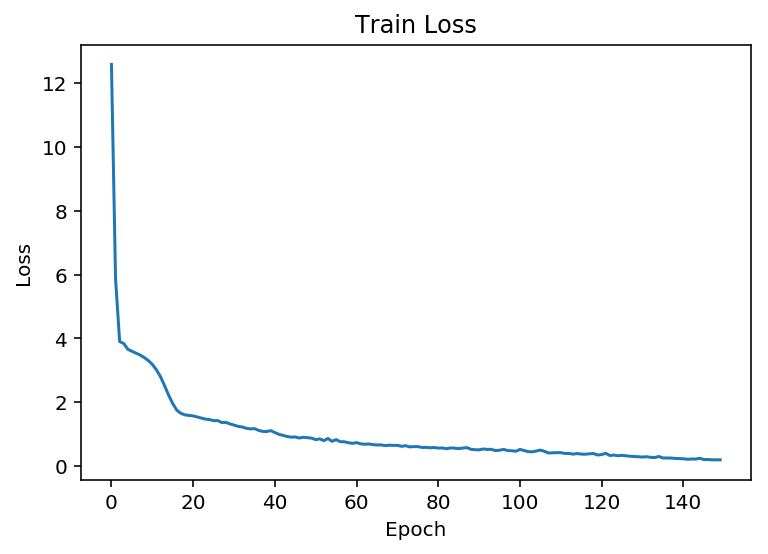

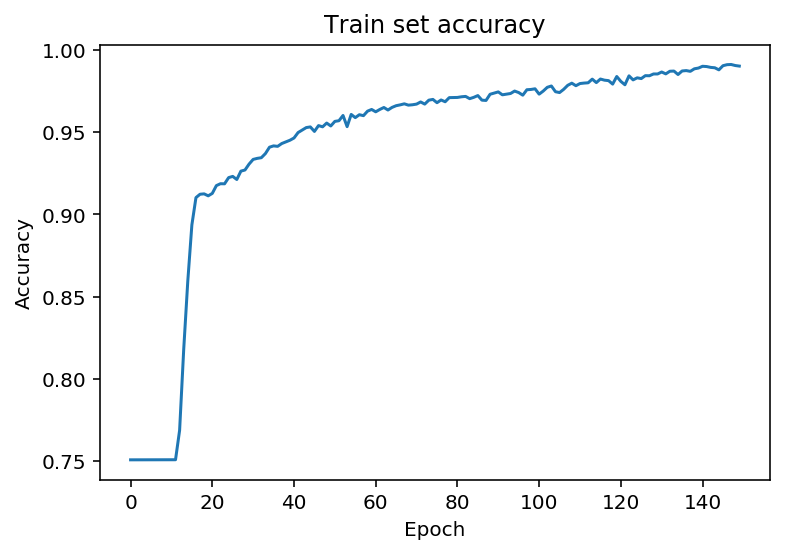

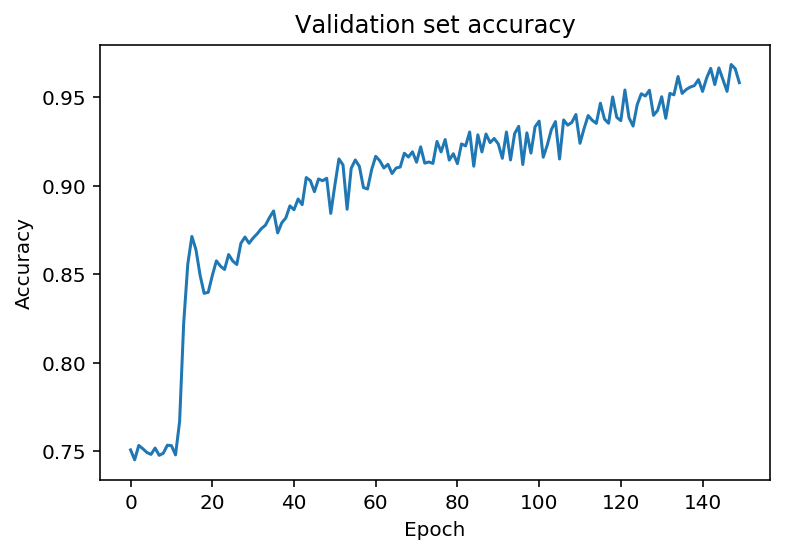

In [11]:
import matplotlib.pyplot as plt

plt.plot(history_epoch, history_train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

plt.plot(history_epoch, history_train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train set accuracy')
plt.show()

plt.plot(history_epoch, history_validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation set accuracy')
plt.show()

In [ ]:
# obtain one batch of test images
display_size = 10

## TODO: crear un conjunto de validación
dataiter = iter(testloader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(model(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.numpy().transpose((1, 2, 0))
    image = (image + np.ones(image.shape))/2
    ax.imshow(image)
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [12]:
# Print the confusion matrix

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Implementamos una función de evaluación
def print_confusion_matrix(model, testloader, class_names):
    
    all_labels = np.array([])
    all_predictions = np.array([])
    for images, labels in testloader:

        # warp input images in a Variable wrapper
        images = Variable(images)
        images = images.to(device)
        
        labels = Variable(labels)
        labels = labels.to(device)
        
        output = model.forward(images)
        
        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(output.data, 1)
        
        all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=0)
        all_predictions = np.concatenate((all_predictions, predicted.cpu().numpy()), axis=0)
        
    # Compute confusion matrix
    print(all_labels)
    print(all_predictions)
    
    cnf_matrix = confusion_matrix(all_labels, all_predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
    
    plt.savefig('confusion_matrix.eps', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='eps',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    
    
    plt.savefig('norm_confusion_matrix.eps', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='eps',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

    plt.show()
        
    return


[0. 0. 0. ... 0. 0. 1.]
[0. 0. 0. ... 0. 0. 1.]
Confusion matrix, without normalization
[[13021   115]
 [   54  4310]]
Normalized confusion matrix
[[0.99 0.01]
 [0.01 0.99]]


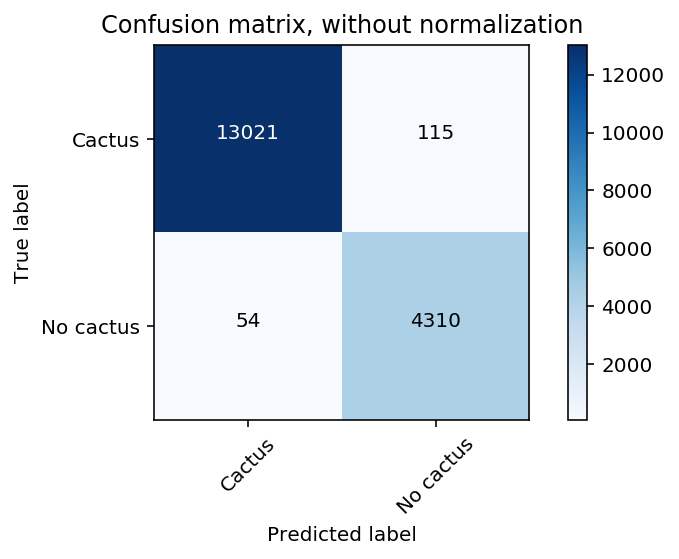

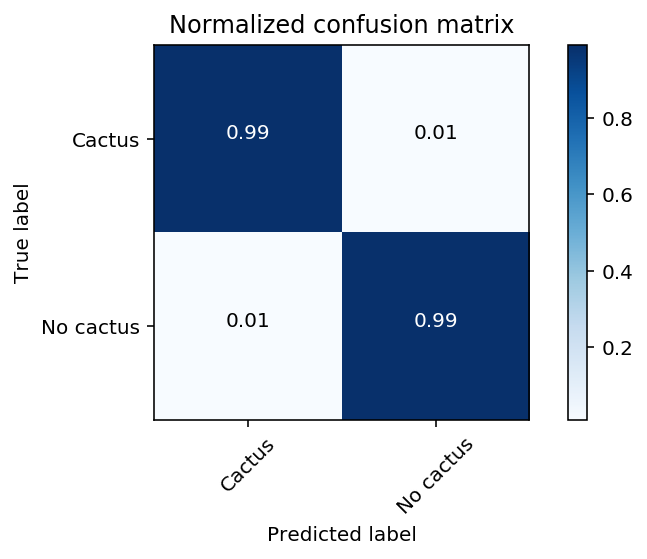

In [20]:
classes = ['Cactus', 'No cactus']
print_confusion_matrix(model, trainloader, classes)


In [14]:
# save parameters
torch.save(model.state_dict(), saving_weights_file)

In [15]:
# save metrics
#from tempfile import TemporaryFile
#outfile = TemporaryFile()

np.save('log/train_loss', history_train_loss)
np.save('log/validation_loss', history_validation_loss)
np.save('log/train_accuracy', history_train_accuracy)
np.save('log/validation_accuracy', history_validation_accuracy)

## Feature visualization

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = model.conv1.weight.data.cpu()

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

## Feature maps

In [ ]:
##TODO: load in and display any image from the transformed test dataset
import matplotlib.image as mpimg
import cv2
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

image = mpimg.imread('cactus_dataset2/training_set/cactus/cactus_0155_91.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.
plt.imshow(image, cmap='gray');

In [ ]:
filter_index = 2
filter_kernel = w[filter_index][0]

filtered_image = cv2.filter2D(image, -1, filter_kernel)

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(7,14))
ax1.imshow(filter_kernel, cmap='gray')
ax2.imshow(filtered_image, cmap='gray')

ax1.set_title('Kernel')
ax2.set_title('Feature map')
plt.tight_layout();